# Mangaging bias when identifying toxic comments - EDA & Initial cleaning

The goal for our work is to not only train a model to identify toxic comments, but to do so while reducing bias.
Bias in this task can be viewed as the situation where certain identies such as 'Black', 'Muslim', 'Gay' e.t.c, begin triggering toxic classification for comments they are in, even when the comment is actually positive. This is a key issue in toxic comment classification. 

The goal of the [jigsaw unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data) Kaggle challenge was to reduce this bias via a newly developed submetric which we have defined below.

**Note: The goal of the model is simply to predict the toxicity score of a model. The bias weighted ROC metric below is calulated from the additional identity labels provided as part of the test set, but the test set goal is only the prediction of toxicity. The labels of the test set were previously withheld, however since the competitionis over we can calculate our own metrics for the test set**

### Process:

This is primarily an NLP task, though we have been provided some additional metadata, we will only be using the text column as our features.

We will attempt to solve this problem using a neural network, and baseline linear models.

----

## Training Data:
We will work on the Training data first. Cleaning steps will be replicated on the test data set.

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
%config InlineBackend.figure_format='retina' #Sharpens matplotlib outputs on Retina resolution displays

In [2]:
# load data
train_df = pd.read_csv('data/train.csv')

## Exploring the data

In [3]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.00,"This is so cool. It's like, 'would you want yo...",0.00,0.00,0.00,0.00,0.00,nan,nan,...,2006,rejected,0,0,0,0,0,0.00,0,4
1,59849,0.00,Thank you!! This would make my life a lot less...,0.00,0.00,0.00,0.00,0.00,nan,nan,...,2006,rejected,0,0,0,0,0,0.00,0,4
2,59852,0.00,This is such an urgent design problem; kudos t...,0.00,0.00,0.00,0.00,0.00,nan,nan,...,2006,rejected,0,0,0,0,0,0.00,0,4
3,59855,0.00,Is this something I'll be able to install on m...,0.00,0.00,0.00,0.00,0.00,nan,nan,...,2006,rejected,0,0,0,0,0,0.00,0,4
4,59856,0.89,haha you guys are a bunch of losers.,0.02,0.00,0.02,0.87,0.00,0.00,0.00,...,2006,rejected,0,0,0,1,0,0.00,4,47


In [4]:
len(train_df)

1804874

There are 1.8m comments and 45 columns in the dataset including the target column.

In [5]:
train_df.dtypes

id                                       int64
target                                 float64
comment_text                            object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float64
jewish                                 float64
latino                                 float64
male         

### Dropping uneeded columns

The dataset comes with a number of potentially useful metadata columns for further analysis. However for the purposes of this project we are focussing on using NLP processes and models on the 'comment_text' column. In addition to this, we will only keep the identity columns that the Kaggle competition used for evaluation. 

In [6]:
# list of cols to keep 
cols_to_keep = ['id', 'target', 'comment_text',
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# drop all columns not in above list
train_df.drop([i for i in train_df.columns if i not in cols_to_keep], axis=1, inplace=True)

### Investigating Null Values

In [7]:
train_df.isna().sum()

id                                     0
target                                 0
comment_text                           0
black                            1399744
christian                        1399744
female                           1399744
homosexual_gay_or_lesbian        1399744
jewish                           1399744
male                             1399744
muslim                           1399744
psychiatric_or_mental_illness    1399744
white                            1399744
dtype: int64

There appears to be a systemic reason behind the null values for the identy label columns. According to the Kaggle description, only a subste of columns, where a specific identity was mentioned had these identy labels mentioned. Lets check whether this is the case (i.e for the non_nulls we should see all the identity columns filled)

In [8]:
# picking out the non_nulls with asian column, any of the identity columns could be used
train_df[train_df['black'].isna() == False].isna().sum()

id                               0
target                           0
comment_text                     0
black                            0
christian                        0
female                           0
homosexual_gay_or_lesbian        0
jewish                           0
male                             0
muslim                           0
psychiatric_or_mental_illness    0
white                            0
dtype: int64

Our hypothesis was right. Before deciding on how to deal with the nulls, lets look at the value ranges for the identity labels.

In [9]:
train_df[train_df['black'].isna() == False].loc[:,'black':'white'].describe()

,black,christian,female,homosexual_gay_or_lesbian,jewish,male,muslim,psychiatric_or_mental_illness,white
count,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00
mean,0.03,0.10,0.13,0.03,0.02,0.11,0.05,0.01,0.06
std,0.17,0.26,0.31,0.14,0.12,0.27,0.20,0.09,0.22
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


It looks like these values range between 1 and 0. We can replace the NaNs with missing values given that these comments did not mention identity.

In [10]:
# get the identity columns and then loop over them to fillna
columns = train_df.loc[:,'black':'white'].columns
for i in columns:
    train_df[i].fillna(0, inplace=True)

In [11]:
train_df.isna().sum()

id                               0
target                           0
comment_text                     0
black                            0
christian                        0
female                           0
homosexual_gay_or_lesbian        0
jewish                           0
male                             0
muslim                           0
psychiatric_or_mental_illness    0
white                            0
dtype: int64

We have no more null values in the training dataset.

#### Investigating and Converting the target to a binary classifier:
The aim of our analysis is to be able to classify text as toxic or not depending on the text contained, and other metadata. The  target column 'target' is not a binary currently given how it was calculated, however we can simply set all rows where target > 0.5 to be 1 (i.e toxic). We could however carry out this task as a regression problem and predict a toxicity score.

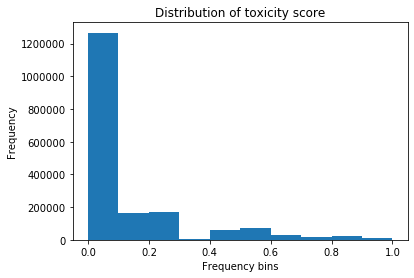

In [12]:
# Plot a histogram for the target column
plt.figure()
plt.hist(train_df['target'])
plt.xlabel('Frequency bins')
plt.ylabel('Frequency')
plt.title('Distribution of toxicity score')
plt.show()

We can see that by far the majority of columns have a low toxicity score. Let us also investigate what the class distribution woul

In [13]:
# first we binarize the target
train_df['target_class'] = np.where(train_df['target']>=0.5, 1, 0)

In [14]:
total_rows = len(train_df['target_class'])
total_toxic = train_df[train_df['target_class'] == 1]['target_class'].count()
total_non_toxic = total_rows - total_toxic
prop_toxic = (total_toxic/total_rows)*100
prop_non_toxic = (total_non_toxic/total_rows)*100

print(f' The total number of toxic comments is {total_toxic}, which is {prop_toxic:.2f}% of the total')
print(f' The total number of non-toxic comments is {total_non_toxic}, which is {prop_non_toxic:.2f}% of the total')

 The total number of toxic comments is 144334, which is 8.00% of the total
 The total number of non-toxic comments is 1660540, which is 92.00% of the total


As we can see, there is significant class imbalance here. This is to be expected given that most comments are not toxic, but this will have to be taken into account during modelling.

### Binarizing the identity and target columns
The aim of our model is to accurately classify toxic comments while reducing the bias from over-associating certain identities with toxicity. The current identity and target columns are not binarized as they are calculated figures from averaging out the human reviewer scores. We will do this now

In [90]:
# Convert taget and identity columns to 1,0
# We are also changing the datatype to int8 to save memory.
cols_to_binarize = train_df.drop(['id','comment_text'], axis=1).columns
    
def convert_df_to_binary(df, cols):
    for col in cols :
        df[col] = np.where(df[col] >= 0.5, 1, 0)
        df[col] = df[col].astype(np.int8)
    return df

train_df = convert_df_to_binary(train_df, cols_to_binarize)

In [91]:
display(train_df.loc[:,cols_to_binarize].describe())
display(train_df['target'].describe())

,target,black,christian,female,homosexual_gay_or_lesbian,jewish,male,muslim,psychiatric_or_mental_illness,white
count,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00
mean,0.08,0.01,0.02,0.03,0.01,0.00,0.01,0.01,0.00,0.01
std,0.27,0.09,0.15,0.17,0.08,0.06,0.10,0.11,0.05,0.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


count   1804874.00
mean          0.08
std           0.27
min           0.00
25%           0.00
50%           0.00
75%           0.00
max           1.00
Name: target, dtype: float64

In [92]:
train_df.dtypes

id                                int64
target                             int8
comment_text                     object
black                              int8
christian                          int8
female                             int8
homosexual_gay_or_lesbian          int8
jewish                             int8
male                               int8
muslim                             int8
psychiatric_or_mental_illness      int8
white                              int8
dtype: object

-------

### Test Data:
Let's apply the same cleaning steps to the test data. For integrity we will make no changes to what we have done on the training data. Given we now have access to both the public and private test sets we will also combine the two.

We will:

1) Drop the same columns as we did above.

2) Fill in NaN's int he identity columns with 0

3) Binarize target and identity columns

But first we have multiple test datasets. We expect this is because the competition organisers released the private test set and also added additional information for further research once the competition is over. Lets explore these datasets to see if this is the case.

In [44]:
# Read in the test csvs
test_df = pd.read_csv('data/test.csv')
test_df_pub = pd.read_csv('data/test_public_expanded.csv')
test_df_prv = pd.read_csv('data/test_private_expanded.csv')

In [21]:
# observing test_df
test_df.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [22]:
len(test_df['id'])

97320

In [23]:
# observing test_df_pub
test_df_pub.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
0,7000000,Jeff Sessions is another one of Trump's Orwell...,2017-01-26 07:37:38.422417+00,13,nan,164149,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,7000001,I actually inspected the infrastructure on Gra...,2016-12-03 20:38:21.204649+00,54,655260.00,154341,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,7000002,No it won't . That's just wishful thinking on ...,2017-05-05 18:07:58.560078+00,21,5219683.00,332005,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,7000003,Instead of wringing our hands and nibbling the...,2017-02-09 14:46:30.189044+00,13,nan,167110,approved,0,0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,7000004,how many of you commenters have garbage piled ...,2016-10-15 01:18:40.521923+00,21,nan,148484,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [24]:
len(test_df_pub['id'])

97320

In [25]:
# observing test_df_prv
test_df_prv.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
0,7097320,[ Integrity means that you pay your debts.]\n\...,2017-09-13 20:12:01.484121+00,21,5945023.00,376974,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,7097321,This is malfeasance by the Administrator and t...,2017-05-17 07:01:51.902566+00,55,nan,335003,approved,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,2016-12-02 17:12:12.920957+00,54,649389.00,154126,approved,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,7097323,"Paul: Thank you for your kind words. I do, in...",2017-04-21 14:58:05.474657+00,13,5158666.00,328376,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,7097324,Sorry you missed high school. Eisenhower sent ...,2017-10-01 19:43:12.373229+00,102,6061626.00,383983,approved,1,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [26]:
len(test_df_prv['id'])

97320

It would appear that test_df_prv and test_df are duplicates, i.e test_df_prv is just test_df but with the added metadata information.

In [27]:
# To check we are going to loop over the range of the series length and then evaluate the id at each i.
# If the IDs are not equal, we continue, else we append them to the list. This list should be empty if no duplicates
# and if completely duplicated the length will = the number of rows of the dfs 97320

dup_list = []
for i in range(len(test_df_prv['id'])):
    if test_df_prv['id'].loc[i] != test_df['id'].loc[i]:
        continue
    else:
        dup_list.append(test_df_prv['id'].loc[i])
        

In [28]:
print(len(dup_list))

97320


As we can see, test_df which is the test dataset with no identity labels and test_df_prv which is the private test dataset with identity labels are identical. For our purposes we will continue to process test_df_prv in line with what we have stated above. 

In [29]:
# QUick check for duplicates between test_df_prv and test_df_pub
dup_list = []
for i in range(len(test_df_prv['id'])):
    if test_df_prv['id'].loc[i] != test_df_pub['id'].loc[i]:
        continue
    else:
        dup_list.append(test_df_prv['id'].loc[i])

In [30]:
print(len(dup_list))

0


No duplicates between the public and private sets. This means we can combine the two sets to give us a more rich test set to test against now that the competition is closed.

In [45]:
#concat the two datasets
test_df_concat = pd.concat([test_df_pub,test_df_prv], axis=0)

In [46]:
test_df_concat.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
0,7000000,Jeff Sessions is another one of Trump's Orwell...,2017-01-26 07:37:38.422417+00,13,nan,164149,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,7000001,I actually inspected the infrastructure on Gra...,2016-12-03 20:38:21.204649+00,54,655260.00,154341,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,7000002,No it won't . That's just wishful thinking on ...,2017-05-05 18:07:58.560078+00,21,5219683.00,332005,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,7000003,Instead of wringing our hands and nibbling the...,2017-02-09 14:46:30.189044+00,13,nan,167110,approved,0,0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,7000004,how many of you commenters have garbage piled ...,2016-10-15 01:18:40.521923+00,21,nan,148484,approved,0,0,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [47]:
test_df_concat.columns

Index(['id', 'comment_text', 'created_date', 'publication_id', 'parent_id',
       'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'identity_annotator_count',
       'toxicity_annotator_count', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability'],
      dtype='object')

In [33]:
print(len(test_df_concat))

194640


We can now process this combined test set for our purposes.

**NOTE: in the test dataset the target column is called 'toxicity'**

#### Dropping uneeded columns

We will now drop the same columns as we did for the train set

In [48]:
# list of cols to keep 
cols_to_keep = ['id', 'toxicity', 'comment_text',
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# drop all columns not in above list
test_df_concat.drop([i for i in test_df_concat.columns if i not in cols_to_keep], axis=1, inplace=True)

#### Check for nulls

In [49]:
test_df_concat.isna().sum()

id                                    0
comment_text                          0
toxicity                              0
male                             151770
female                           151770
homosexual_gay_or_lesbian        151770
christian                        151770
jewish                           151770
muslim                           151770
black                            151770
white                            151770
psychiatric_or_mental_illness    151770
dtype: int64

It would appear as though a similar pattern as we saw for the train dataset exists here.

In [50]:
# fill nulls in identity columns with 0
columns = test_df_concat.loc[:,'male':'psychiatric_or_mental_illness'].columns
for i in columns:
    test_df_concat[i].fillna(0, inplace=True)

In [51]:
test_df_concat.isna().sum()

id                               0
comment_text                     0
toxicity                         0
male                             0
female                           0
homosexual_gay_or_lesbian        0
christian                        0
jewish                           0
muslim                           0
black                            0
white                            0
psychiatric_or_mental_illness    0
dtype: int64

In [93]:
# binarize identity and target col - we know this is the toxicity column for the test dataset
cols_to_binarize = test_df_concat.drop(['id','comment_text'], axis=1).columns
test_df_concat = convert_df_to_binary(test_df_concat, cols_to_binarize)

In [95]:
display(test_df_concat.loc[:,cols_to_binarize].describe())
display(test_df_concat['toxicity'].describe())

,toxicity,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
count,194640.00,194640.00,194640.00,194640.00,194640.00,194640.00,194640.00,194640.00,194640.00,194640.00
mean,0.08,0.02,0.03,0.01,0.02,0.00,0.01,0.01,0.01,0.00
std,0.27,0.15,0.16,0.07,0.15,0.07,0.10,0.09,0.11,0.05
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


count   194640.00
mean         0.08
std          0.27
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: toxicity, dtype: float64

Everything looks good! Before we save the files to file, lets rename the 'toxicity column in the test dataset to target for consistency.

In [96]:
test_df_concat.rename({'toxicity' : 'target'}, axis=1, inplace=1)

In [97]:
test_df_concat.columns

Index(['id', 'comment_text', 'target', 'male', 'female',
       'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black',
       'white', 'psychiatric_or_mental_illness'],
      dtype='object')

### Output to csv

In [100]:
train_df.to_csv('data/train_clean.csv')

In [101]:
test_df_concat.to_csv('data/test_clean.csv')

----------

## Data Exploration

#### Length of Comments

In [102]:
# Length of comments - first we need to get the number of words per comment 
comment_length = []
for i in range(len(train_df)):
    comment = train_df.loc[i,'comment_text']
    comment_length.append(len(comment.split(' ')))


In [103]:
train_df['comment_len'] = comment_length

In [104]:
x = train_df.loc[614677,'comment_text']

In [105]:
len(x) - len(''.join(x.split())) + 1

854

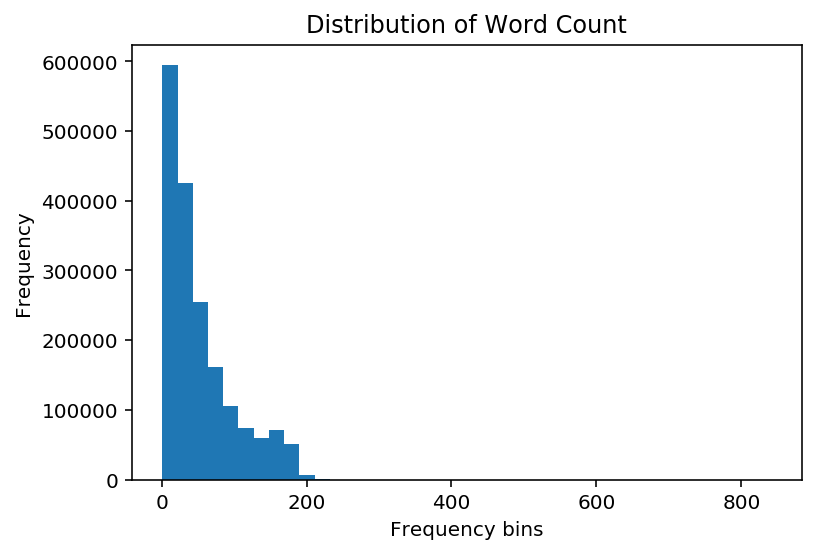

In [113]:
plt.figure()
plt.hist(train_df['comment_len'], bins=40)
plt.xlabel('Frequency bins')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.show()

In [107]:
train_df['comment_len'].describe()

count   1804874.00
mean         51.86
std          46.82
min           1.00
25%          17.00
50%          35.00
75%          73.00
max         841.00
Name: comment_len, dtype: float64

The vast majority of comments have a low word count, with only 6 possessing a wordcount over 500 words. 75% of the data has comment lengths below 73 words. This is a particularly important fact for our planned LSTM model. Longer sequences generally are harder for the network to accurately process given the amount of information that needs to be 'remembered'. In addition to this, we quickly run into memory constraints when parsing numerous long passages.

In [108]:
# Lets now look at character counts.
len_list = []
for i in train_df['comment_text']:
    len_list.append(len(i))

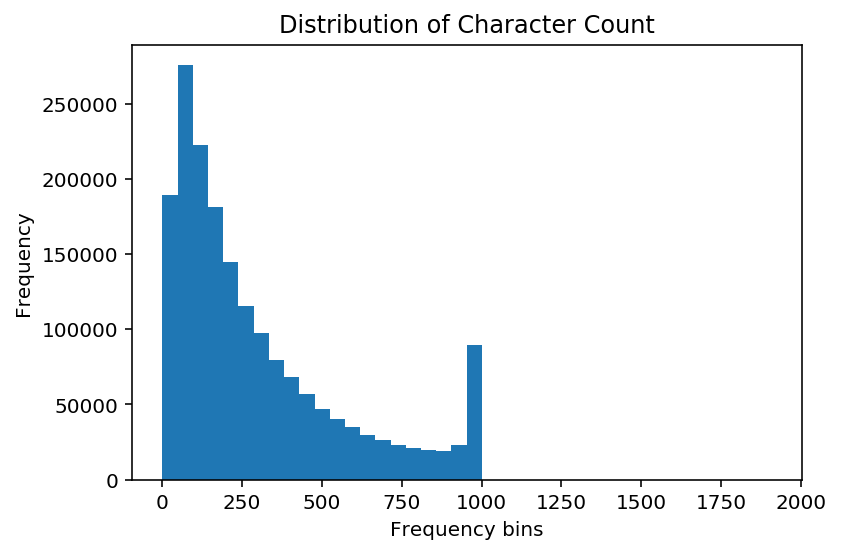

In [114]:
# no need to append onto the dataframe
plt.figure()
plt.hist(len_list, bins=40)
plt.xlabel('Frequency bins')
plt.ylabel('Frequency')
plt.title('Distribution of Character Count')
plt.show()

In terms of characters, we see a somewhat bimodal distribution, with the majority of comments being very short, but another peak appearing around the 1000 character length. This may suggest that certain publications had a default max charachter limit set at 1000.

#### Length of Toxic comments Vs Non Toxic

In [110]:
toxic_df = train_df[train_df['target'] == 1]
non_toxic_df = train_df[train_df['target'] == 0]

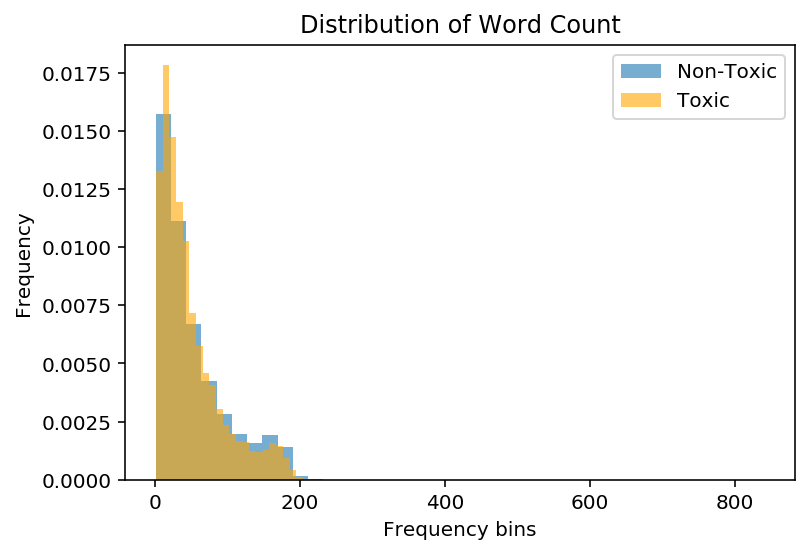

In [115]:
# Density=True normalizes the plot
plt.figure()
plt.hist(non_toxic_df['comment_len'], bins=40,alpha = 0.6, density=True, label='Non-Toxic')
plt.hist(toxic_df['comment_len'], bins=40, color='orange', alpha=0.6, density=True, label='Toxic')
plt.xlabel('Frequency bins')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.legend()
plt.show()


We have normalized the above plots given the differences in absolute count. Comparing the two distributions shows that there does not appear to be any major differences in the distribution of comment lengths of toxic comments to non-toxic comments.